In [5]:
import sys
import os
import site
sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import plotly.express as px
import seaborn as sns # używać więcej
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifierfrom 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
from pprint import pprint
#from sklearn.svm import SVC
from IPython.display import Markdown, display
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
#from sklearnex import patch_sklearn 
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


##Load CSV

In [ ]:
# Dataset from https://www.kaggle.com/datasets/meirnizri/covid19-dataset
df = pd.read_csv('https://raw.githubusercontent.com/AnonymousKnownPerson/covid-project-data/master/Covid%20Data.csv')

#Wprowadzenie

## Zestaw danych został dostarczony przez rząd meksykański. Zestaw ten zawiera ogromną liczbę zanonimizowanych informacji dotyczących pacjentów. Surowy zestaw danych składa się z 21 unikalnych cech i 1 048 575 unikalnych pacjentów. W przypadku cech logicznych, 1 oznacza "tak", a 2 oznacza "nie". Wartości 97, 98 i 99 oznaczają brak danych.

## Dane

**sex**: 1 dla kobiet i 2 dla mężczyzn.

**age**: wskazuje wiek pacjenta.

**classification**: wyniki testu na COVID-19. Wartości 1-3 oznaczają, że pacjent został zdiagnozowany z COVID-19 w różnym stopniu. 4 lub więcej oznacza, że pacjent nie jest nosicielem COVID-19 lub test jest niejednoznaczny.

**patient type**: wskazuje rodzaj opieki, jaką pacjent otrzymał w jednostce. 1 oznacza powrót do domu, a 2 hospitalizację.

**pneumonia**: wskazuje, czy pacjent ma zapalenie pęcherzyków płucnych, czy nie.

**pregnancy**: wskazuje, czy pacjent jest w ciąży, czy nie.

**diabetes**: wskazuje, czy pacjent ma cukrzycę, czy nie.

**copd**: wskazuje, czy pacjent ma przewlekłą obturacyjną chorobę płuc, czy nie.

**asthma**: wskazuje, czy pacjent ma astmę, czy nie.

**inmsupr**:wskazuje,  czy pacjent jest immunosupresyjny, czy nie.

**hypertension**: wskazuje, czy pacjent ma nadciśnienie, czy nie.

**cardiovascular**: wskazuje, czy pacjent ma chorobę serca lub naczyń krwionośnych.

**renal chronic**: wskazuje, czy pacjent ma przewlekłą chorobę nerek, czy nie.

**other disease**: wskazuje, czy pacjent ma inne choroby, czy nie.

**obesity**: wskazuje, czy pacjent jest otyły, czy nie.

**tobacco**: wskazuje, czy pacjent jest palaczem tytoniu.

**usmr**: wskazuje, czy pacjent był leczony w jednostkach medycznych pierwszego, drugiego lub trzeciego poziomu.

**medical unit**: rodzaj instytucji Systemu Zdrowia Narodowego, która świadczyła opiekę.

**intubed**: wskazuje, czy pacjent był podłączony do respiratora.

**icu**: wskazuje, czy pacjent był przyjęty do oddziału intensywnej opieki.

**date died**: jeśli pacjent zmarł, podano datę śmierci; w przeciwnym razie podano
9999-99-99.


##Prezentacja Danych

In [ ]:
df.iloc[0:10,:]

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
5,2,1,1,2,9999-99-99,2,1,40,2,2,...,2,2,2,2,2,2,2,2,3,2
6,2,1,1,1,9999-99-99,97,2,64,2,2,...,2,2,2,2,2,2,2,2,3,97
7,2,1,1,1,9999-99-99,97,1,64,2,1,...,2,1,1,2,2,2,1,2,3,97
8,2,1,1,2,9999-99-99,2,2,37,2,1,...,2,2,1,2,2,1,2,2,3,2
9,2,1,1,2,9999-99-99,2,2,25,2,2,...,2,2,2,2,2,2,2,2,3,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

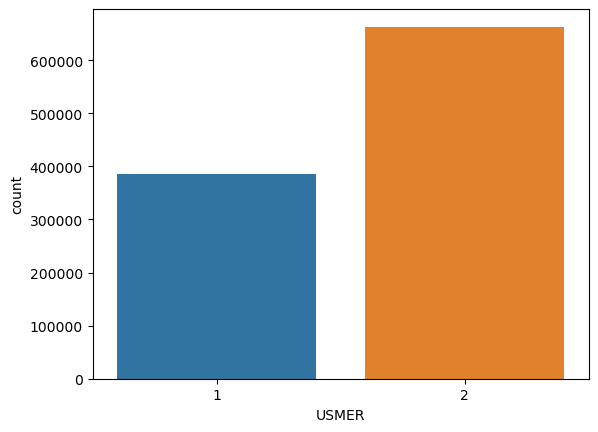

In [ ]:
p = sns.countplot(data=df, x="USMER")
plt.show()

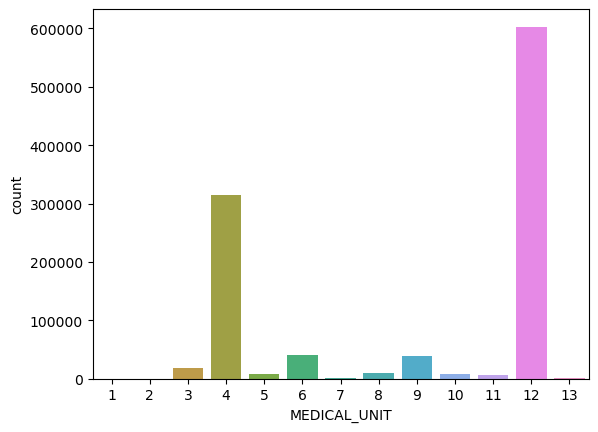

In [ ]:
p = sns.countplot(data=df, x="MEDICAL_UNIT")
plt.show()

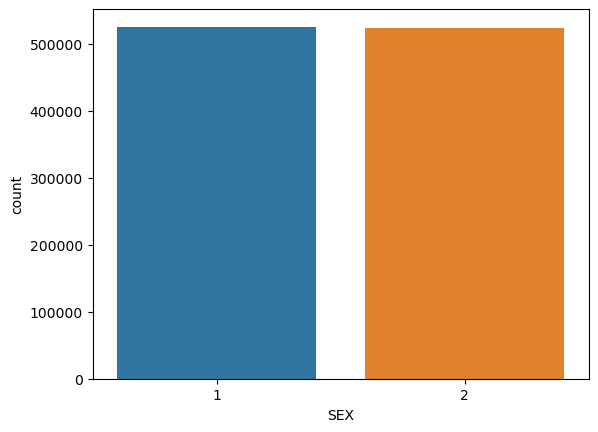

In [ ]:
p = sns.countplot(data=df, x="SEX")
plt.show()

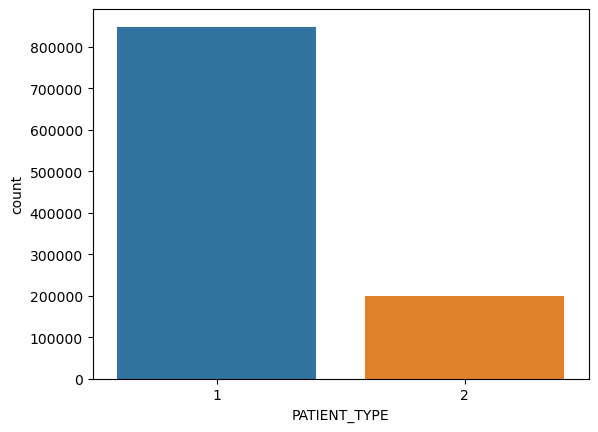

In [ ]:
p = sns.countplot(data=df, x="PATIENT_TYPE")
plt.show()

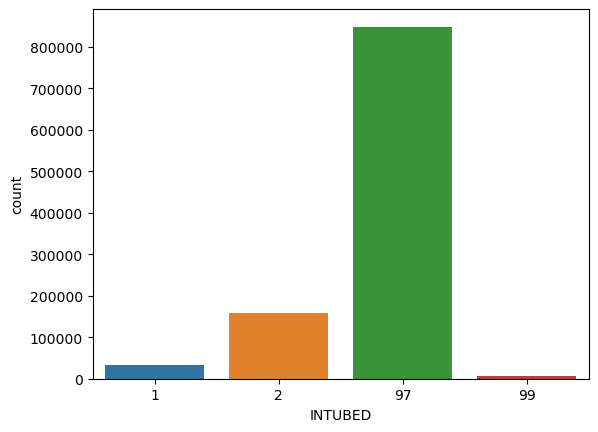

In [ ]:
p = sns.countplot(data=df, x="INTUBED")
plt.show()

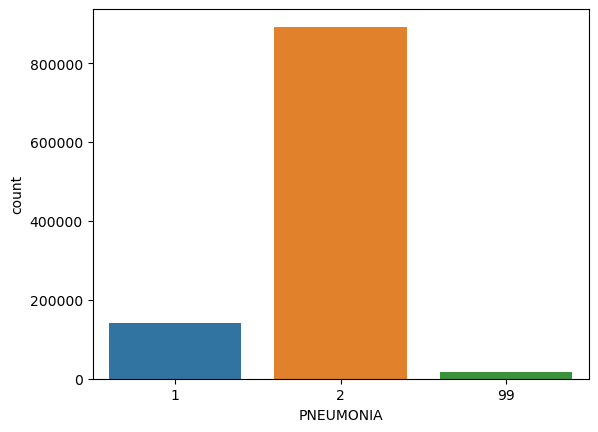

In [ ]:
p = sns.countplot(data=df, x="PNEUMONIA")
plt.show()

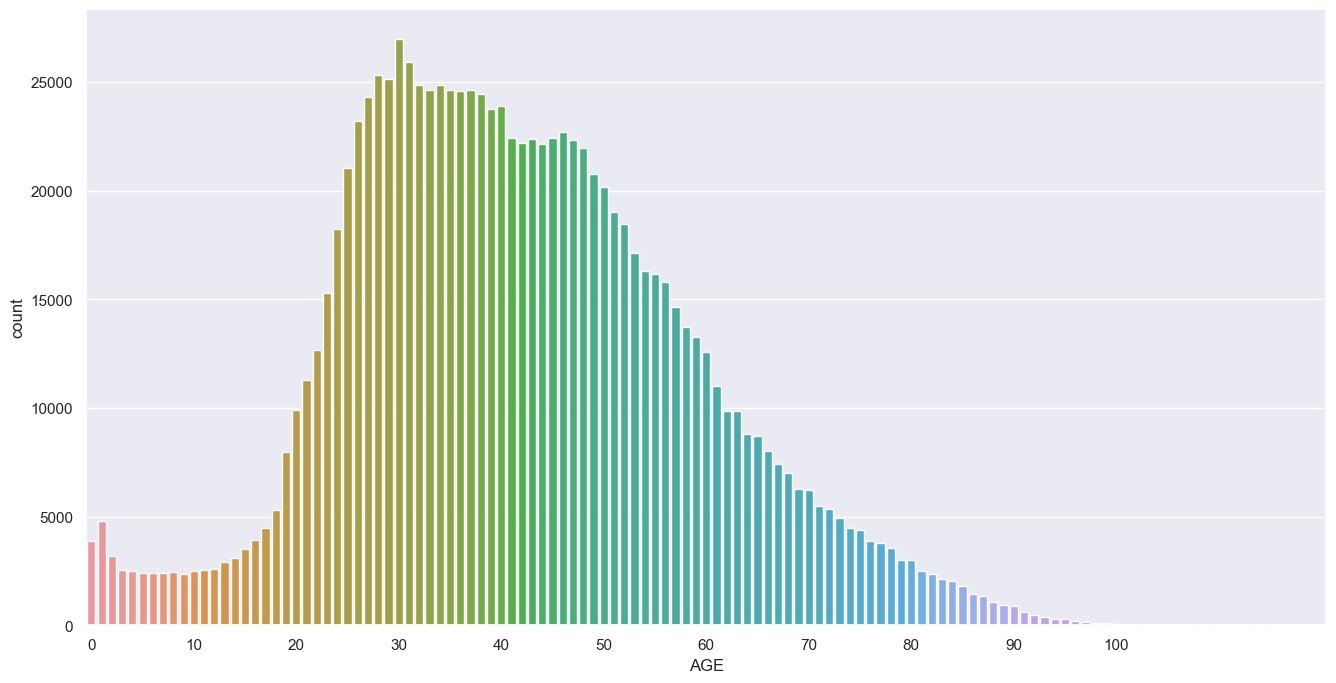

In [ ]:
sns.set(rc={'figure.figsize':(16,8)})
p = sns.countplot(data=df, x="AGE")
plt.xticks(range(0,107, 10))
plt.show()

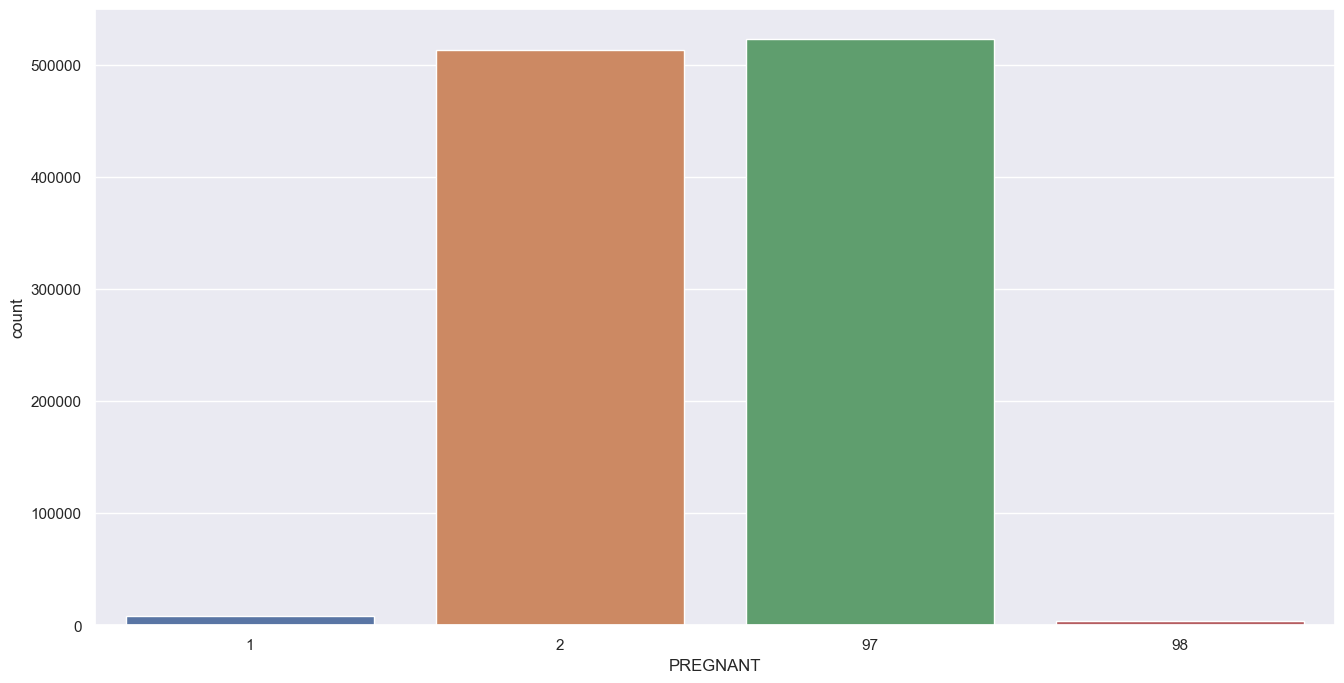

In [ ]:
p = sns.countplot(data=df, x="PREGNANT")
plt.show()

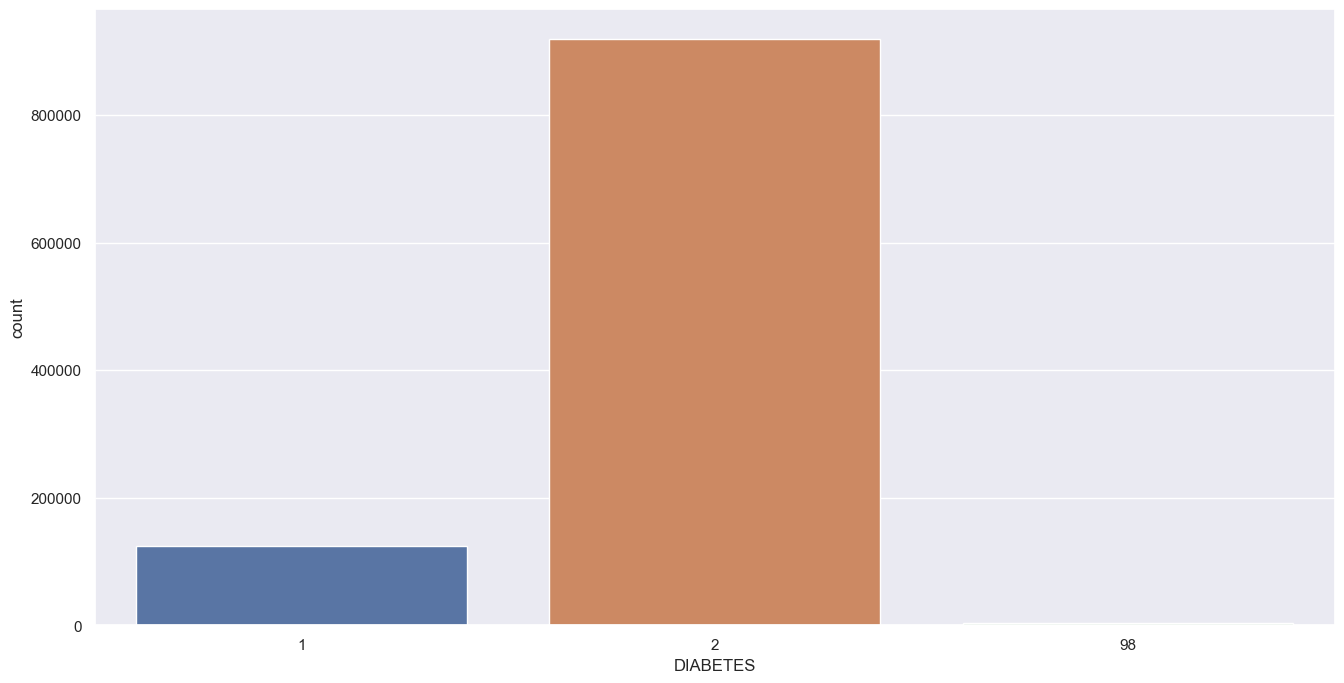

In [ ]:
p = sns.countplot(data=df, x="DIABETES")
plt.show()

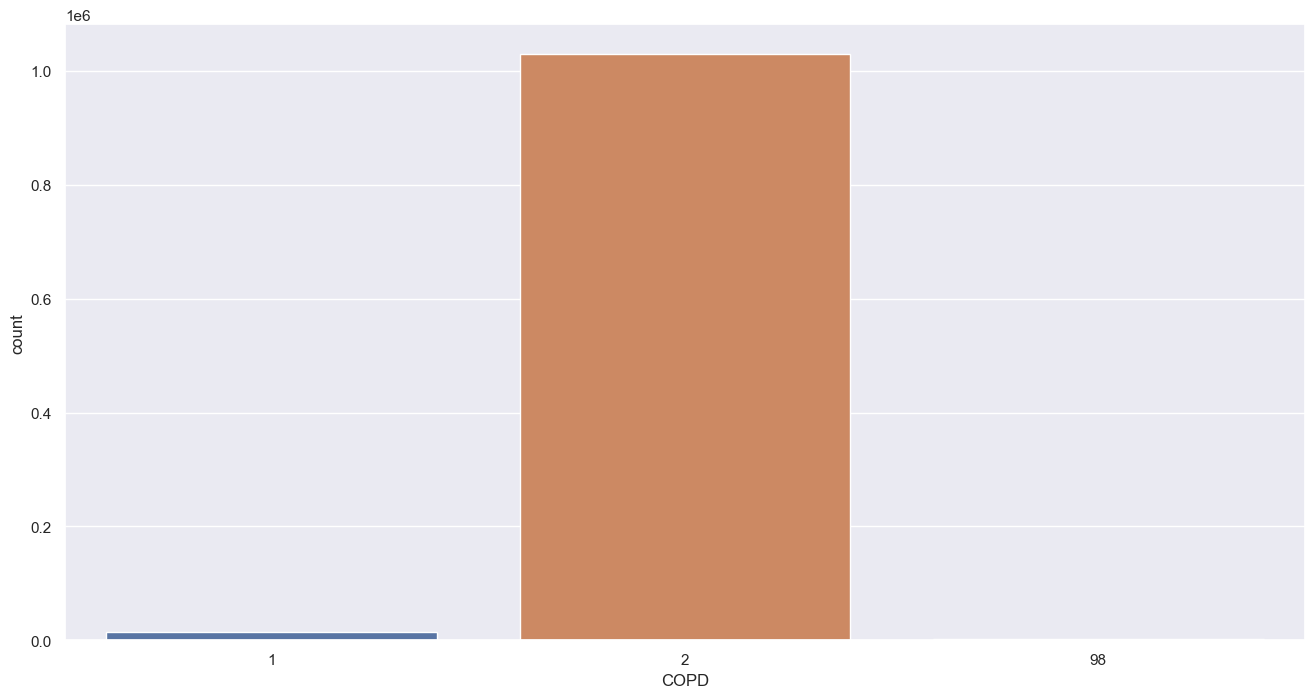

In [ ]:
p = sns.countplot(data=df, x="COPD")
plt.show()

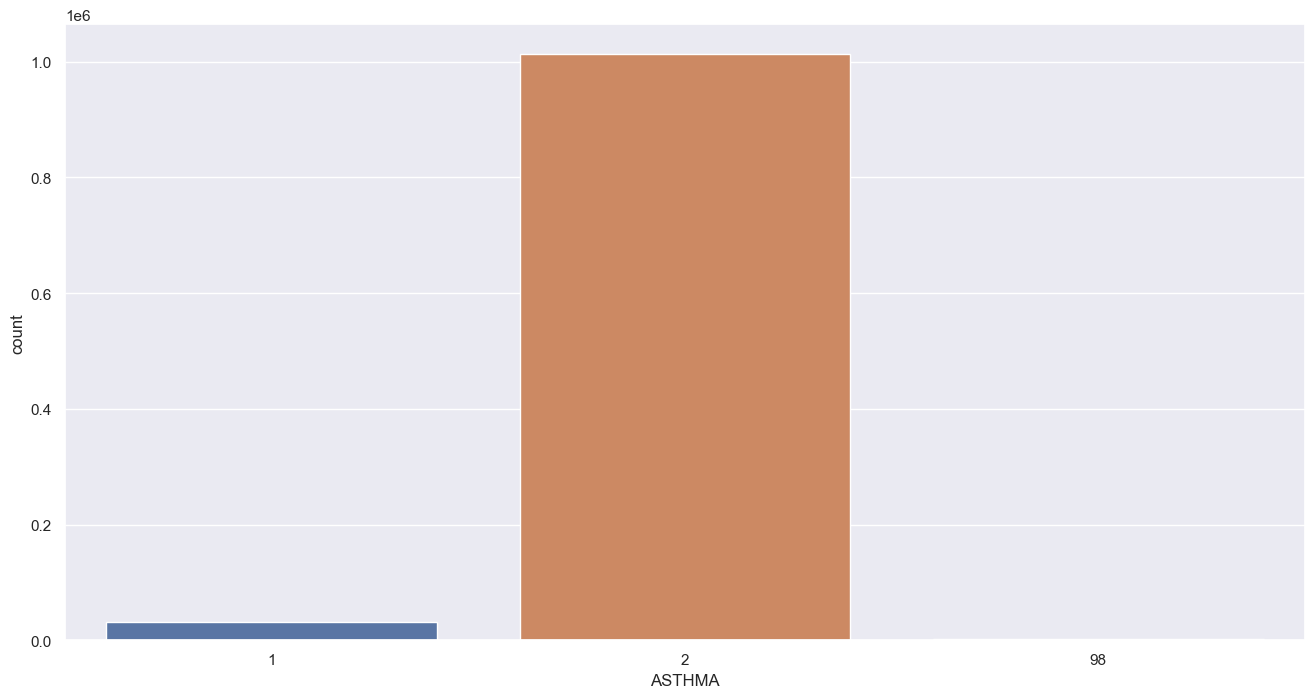

In [ ]:
p = sns.countplot(data=df, x="ASTHMA")
plt.show()

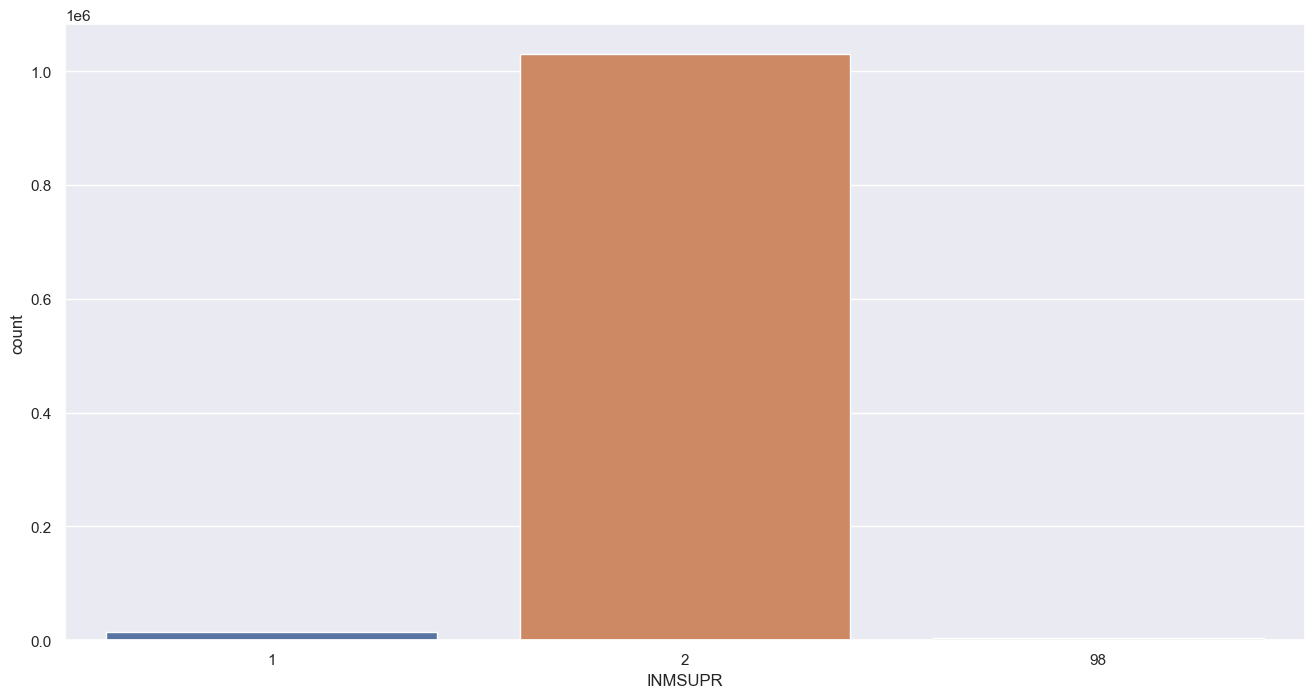

In [ ]:
p = sns.countplot(data=df, x="INMSUPR")
plt.show()

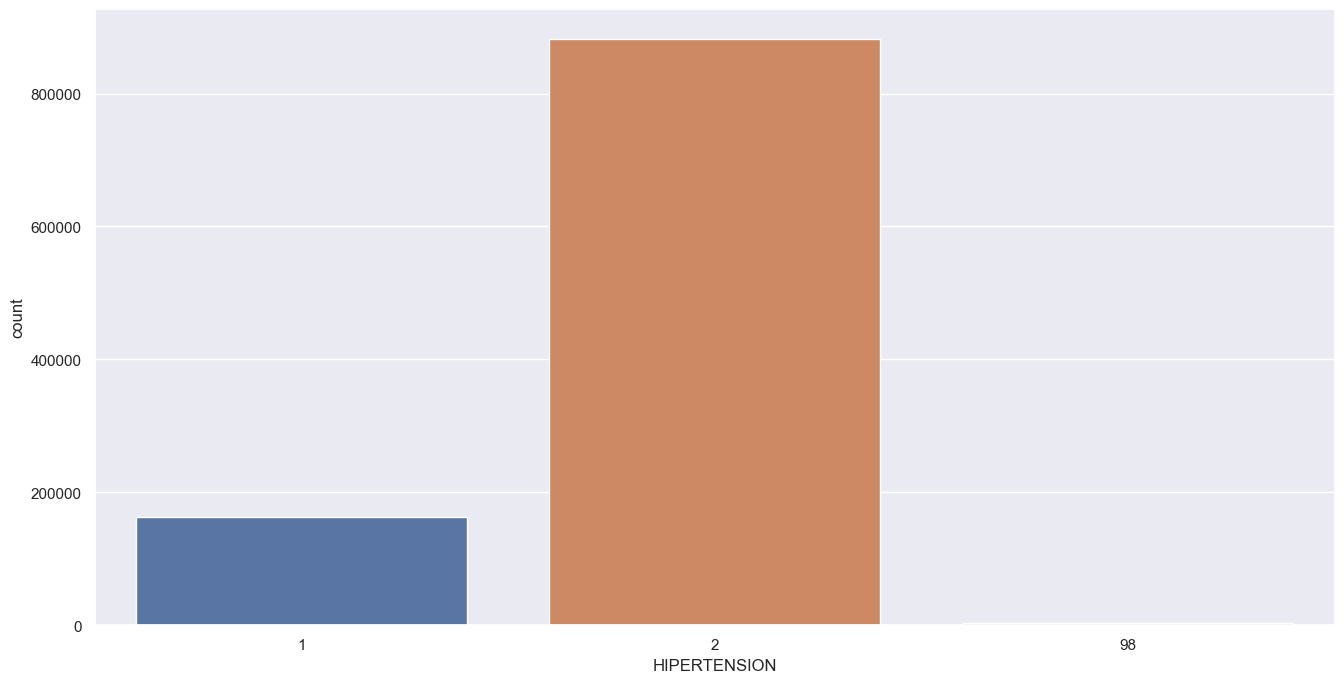

In [ ]:
p = sns.countplot(data=df, x="HIPERTENSION")
plt.show()

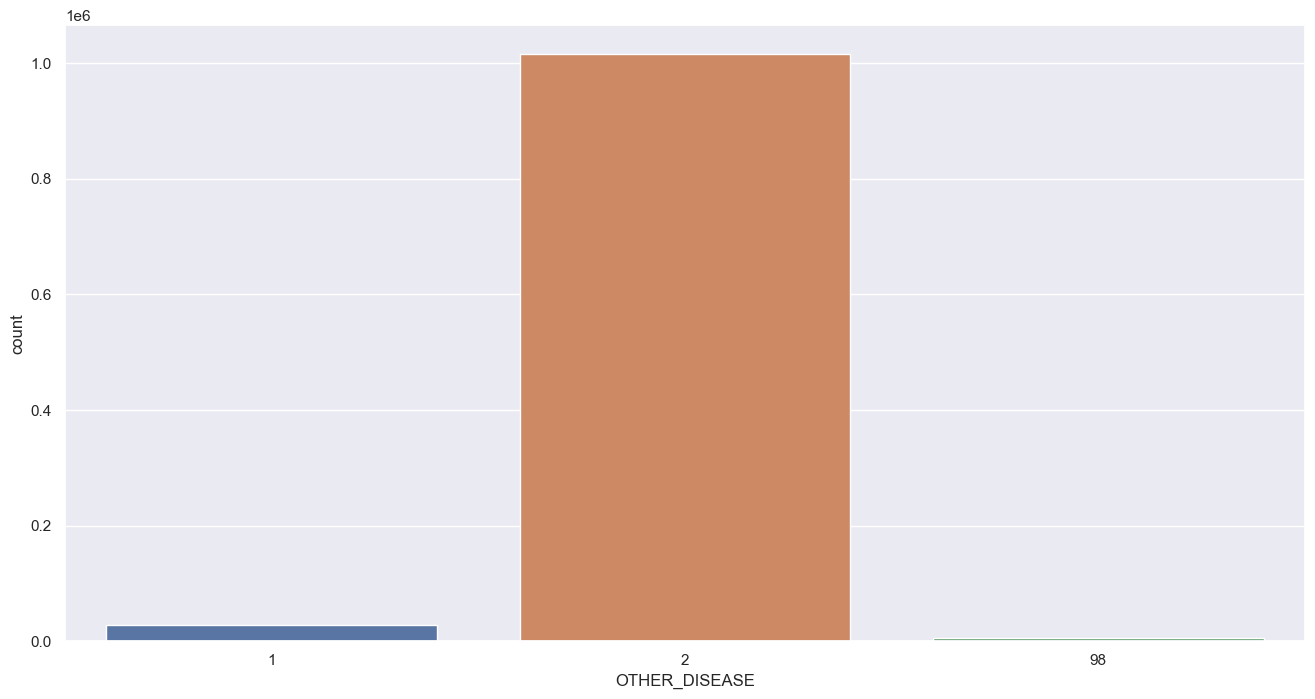

In [ ]:
p = sns.countplot(data=df, x="OTHER_DISEASE")
plt.show()

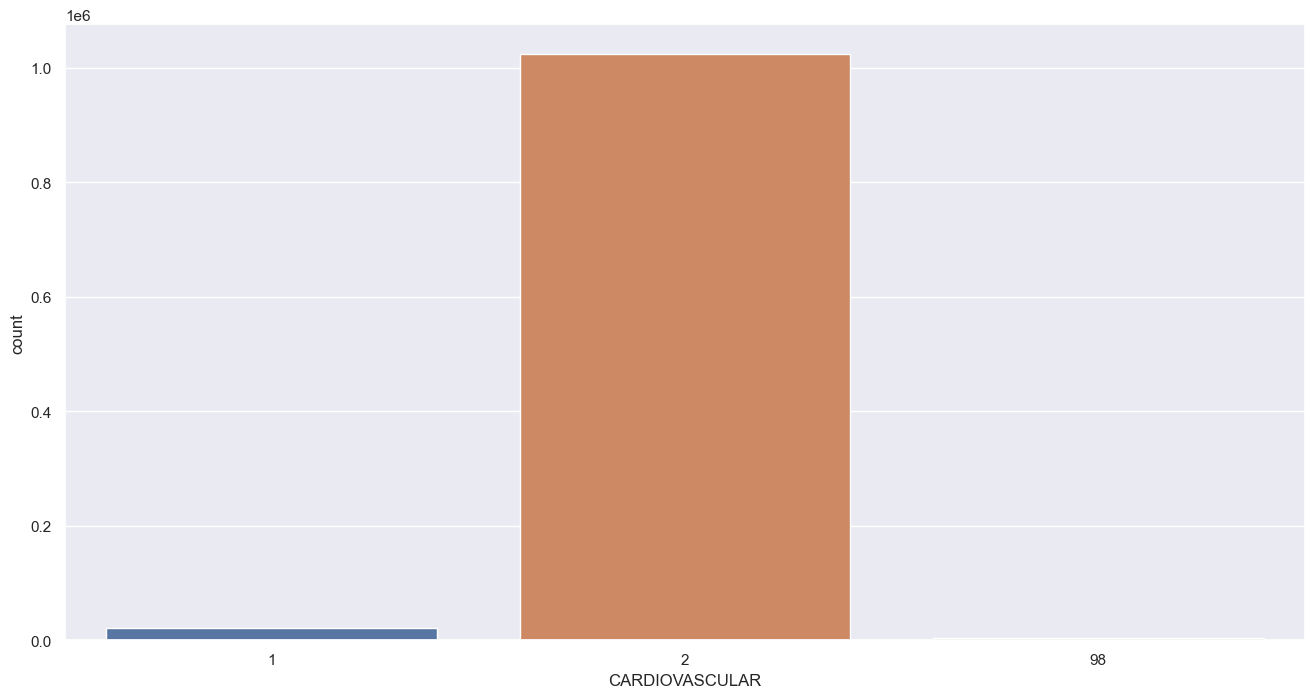

In [ ]:
p = sns.countplot(data=df, x="CARDIOVASCULAR")
plt.show()

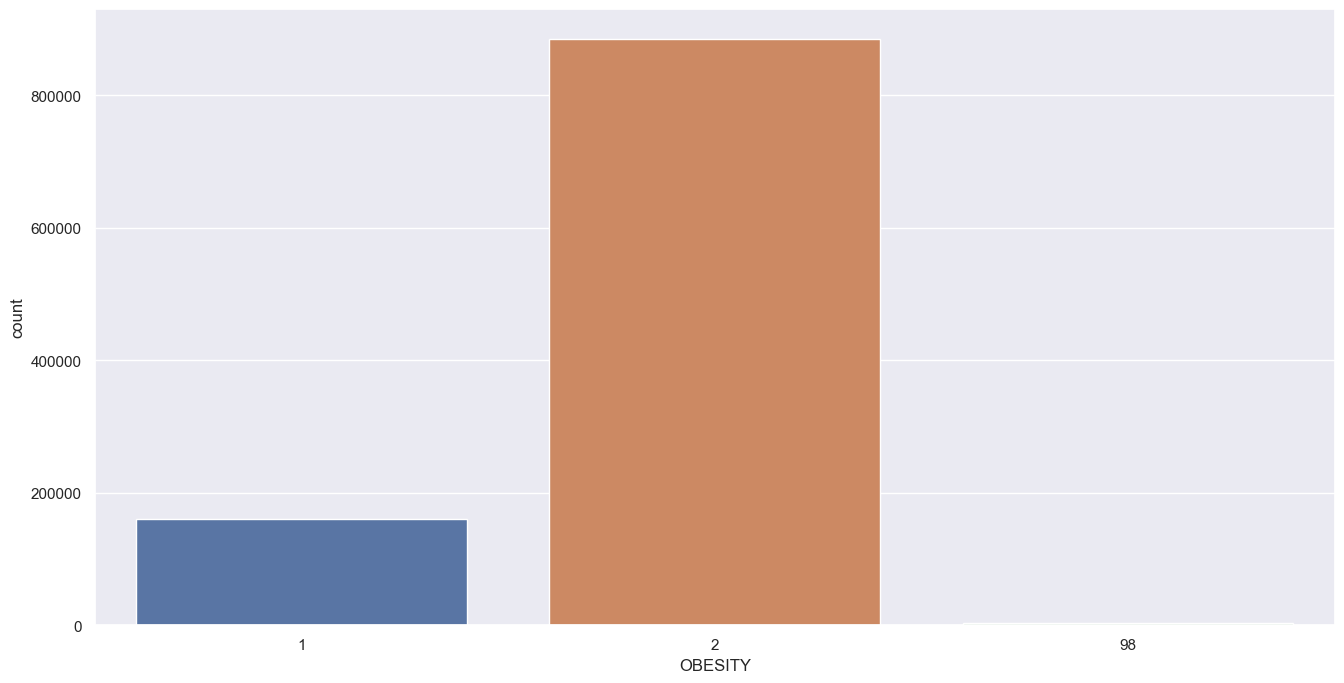

In [ ]:
p = sns.countplot(data=df, x="OBESITY")
plt.show()

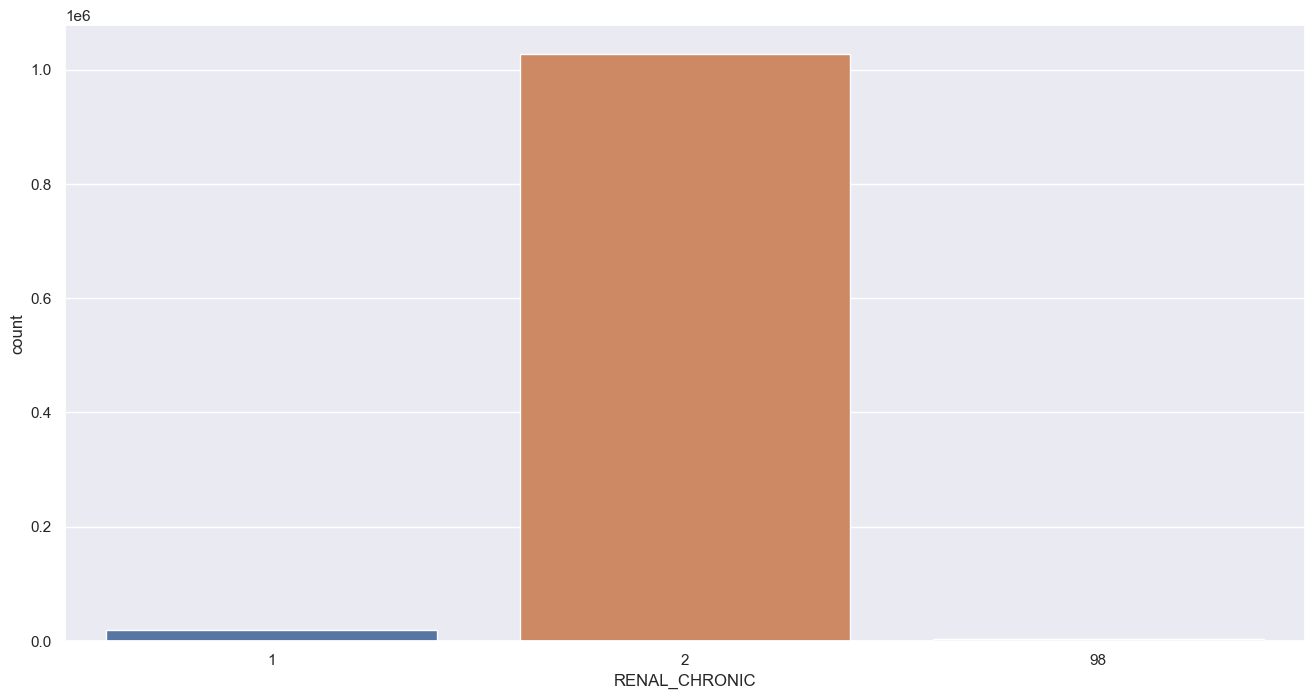

In [ ]:
p = sns.countplot(data=df, x="RENAL_CHRONIC")
plt.show()

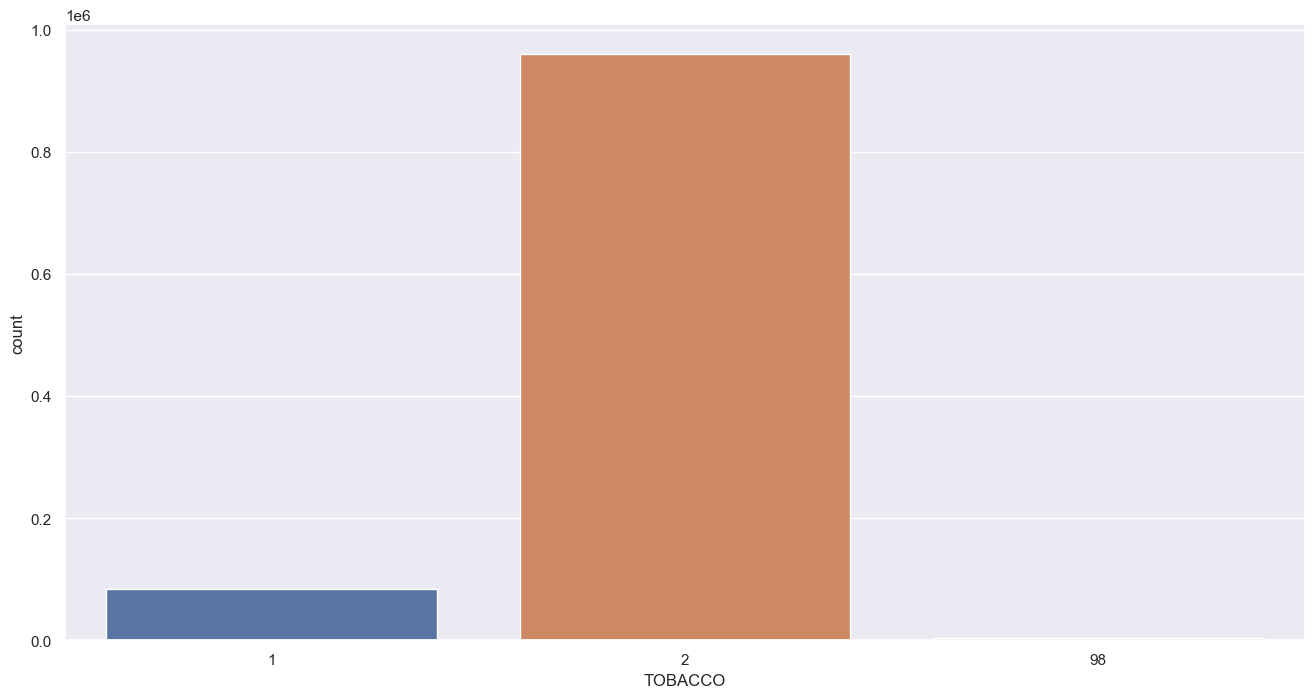

In [ ]:
p = sns.countplot(data=df, x="TOBACCO")
plt.show()

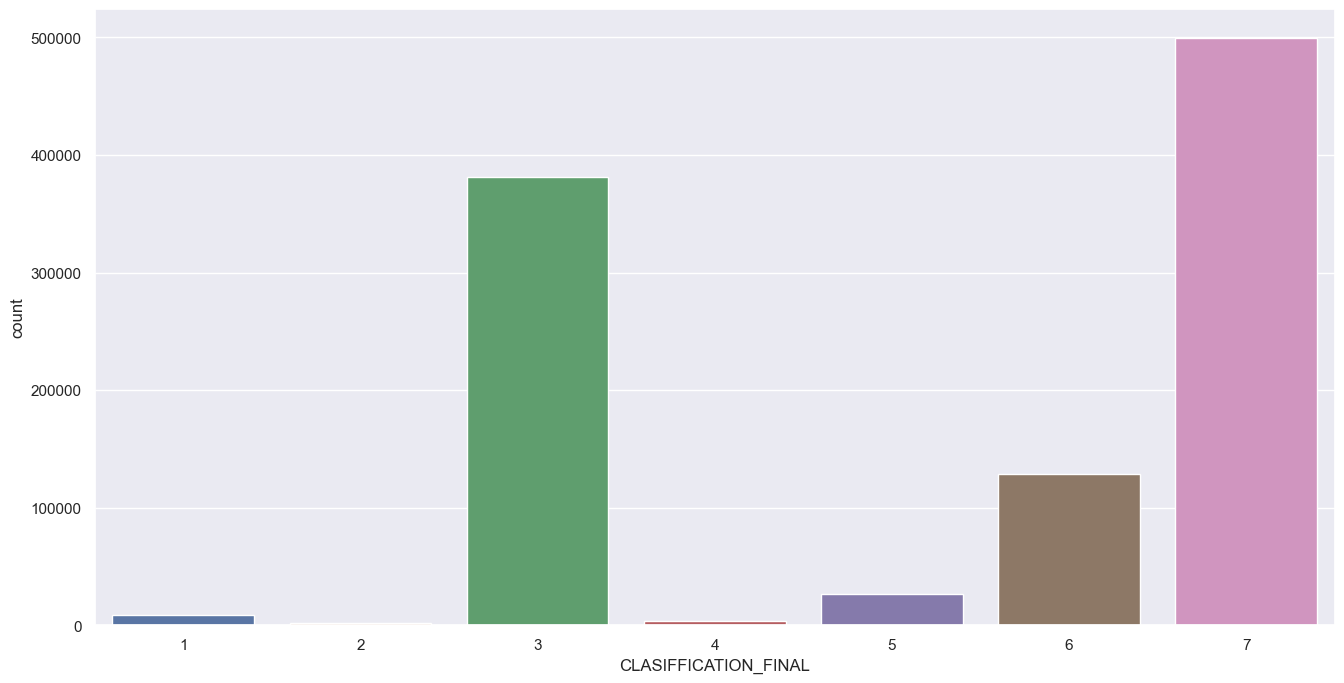

In [ ]:
p = sns.countplot(data=df, x="CLASIFFICATION_FINAL")
plt.show()

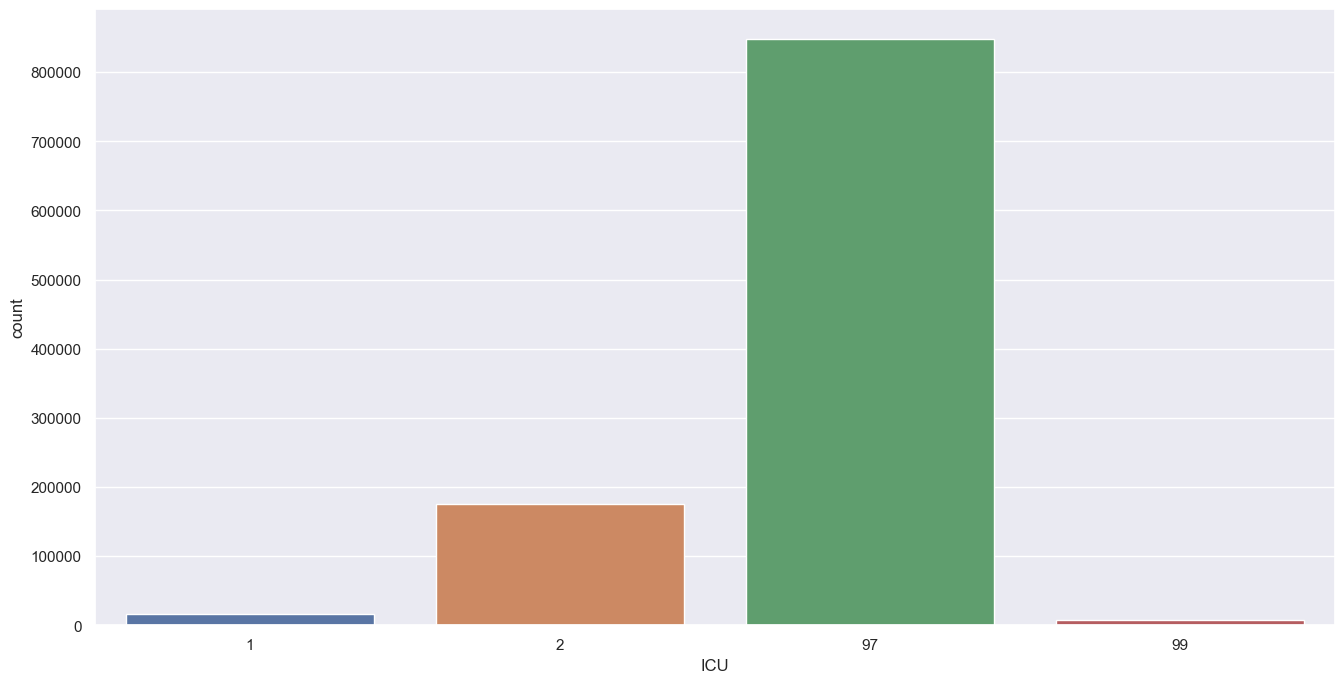

In [ ]:
p = sns.countplot(data=df, x="ICU")
plt.show()

##Macierz Koleracji Atrybutów

In [ ]:
px.imshow(df.corr(),title="Macierz korelacji atrybutów")

In [ ]:
df.corr()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
USMER,1.000000,0.127927,-0.001126,-0.190570,0.175457,-0.154950,-0.045088,-0.001469,0.014704,0.011030,0.010814,0.003234,0.014830,-0.015763,0.010097,0.014567,0.011527,0.010638,0.028840,0.174901
MEDICAL_UNIT,0.127927,1.000000,0.001475,-0.205413,0.205243,-0.046433,-0.082223,0.005300,0.019523,0.014209,0.013312,0.011785,0.020964,0.027453,0.014406,0.019577,0.014751,0.012282,0.079981,0.205141
SEX,-0.001126,0.001475,1.000000,0.089505,-0.089943,-0.012131,0.028367,0.992713,0.008888,0.009372,0.010415,0.007999,0.009257,0.009039,0.008174,0.009858,0.008249,0.004919,-0.057782,-0.089844
PATIENT_TYPE,-0.190570,-0.205413,0.089505,1.000000,-0.976335,0.022966,0.315193,0.088340,0.008743,0.019548,0.023042,0.024924,0.006852,0.036724,0.022175,0.019650,0.018873,0.022123,-0.183370,-0.975810
INTUBED,0.175457,0.205243,-0.089943,-0.976335,1.000000,0.079743,-0.317945,-0.088097,-0.009215,-0.020124,-0.023446,-0.024140,-0.007628,-0.035404,-0.022442,-0.020217,-0.019309,-0.022428,0.193075,0.999434
PNEUMONIA,-0.154950,-0.046433,-0.012131,0.022966,0.079743,1.000000,-0.073127,-0.007284,-0.004484,-0.005618,-0.005392,-0.000802,-0.004799,0.001612,-0.004758,-0.004276,-0.005287,-0.004325,0.075351,0.079691
AGE,-0.045088,-0.082223,0.028367,0.315193,-0.317945,-0.073127,1.000000,0.027257,0.004422,0.019048,0.022715,0.022820,-0.004964,0.022837,0.019489,0.015500,0.020124,0.021263,-0.152637,-0.317813
PREGNANT,-0.001469,0.005300,0.992713,0.088340,-0.088097,-0.007284,0.027257,1.000000,0.014707,0.015736,0.016765,0.014265,0.015335,0.014175,0.014378,0.015895,0.014392,0.010794,-0.057809,-0.087991
DIABETES,0.014704,0.019523,0.008888,0.008743,-0.009215,-0.004484,0.004422,0.014707,1.000000,0.828823,0.829349,0.781108,0.835018,0.634611,0.809417,0.752739,0.812657,0.771763,-0.004739,-0.009223
COPD,0.011030,0.014209,0.009372,0.019548,-0.020124,-0.005618,0.019048,0.015736,0.828823,1.000000,0.908929,0.852273,0.855249,0.687323,0.880097,0.814868,0.884032,0.836097,-0.010336,-0.020146


In [ ]:
df.describe()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.632194e+00,8.980565e+00,1.499259e+00,1.190765e+00,7.952288e+01,3.346831e+00,4.179410e+01,4.976558e+01,2.186404e+00,2.260569e+00,2.242626e+00,2.298132e+00,2.128989e+00,2.435143e+00,2.261810e+00,2.125176e+00,2.257180e+00,2.214333e+00,5.305653e+00,7.955397e+01
std,4.822084e-01,3.723278e+00,4.999997e-01,3.929041e-01,3.686889e+01,1.191288e+01,1.690739e+01,4.751073e+01,5.424242e+00,5.132258e+00,5.114089e+00,5.462843e+00,5.236397e+00,6.646676e+00,5.194850e+00,5.175445e+00,5.135354e+00,5.323097e+00,1.881165e+00,3.682307e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,4.000000e+00,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,3.000000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.700000e+01
50%,2.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,4.000000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00,9.700000e+01
75%,2.000000e+00,1.200000e+01,2.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,5.300000e+01,9.700000e+01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,9.700000e+01
max,2.000000e+00,1.300000e+01,2.000000e+00,2.000000e+00,9.900000e+01,9.900000e+01,1.210000e+02,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,7.000000e+00,9.900000e+01


#Edycja bazy danych


##Sprecyzowanie zbioru danych

In [ ]:
df = df[df['CLASIFFICATION_FINAL'] < 4]

##Usunięcie wybranych brakujących danych z zbioru danych

In [ ]:
columns_to_check = ['TOBACCO', 'RENAL_CHRONIC', 'OBESITY', 'CARDIOVASCULAR', 'OTHER_DISEASE',
                     'HIPERTENSION', 'INMSUPR', 'ASTHMA', 'COPD', 'DIABETES', 'PNEUMONIA']

df[columns_to_check] = df[columns_to_check].replace({97: np.nan, 98: np.nan, 99: np.nan})
missing_values = df[columns_to_check].isnull().sum()

headers = ["Column", "Sum of Missing"]
table = f"| {' | '.join(headers)} |\n|{'|'.join(['---']*len(headers))}|\n"
table += '\n'.join([f"| {col} | {val} |" for col, val in missing_values.items()])

display(Markdown(table))

| Column | Sum of Missing |
|---|---|
| TOBACCO | 1434 |
| RENAL_CHRONIC | 1350 |
| OBESITY | 1353 |
| CARDIOVASCULAR | 1391 |
| OTHER_DISEASE | 2136 |
| HIPERTENSION | 1388 |
| INMSUPR | 1449 |
| ASTHMA | 1309 |
| COPD | 1313 |
| DIABETES | 1440 |
| PNEUMONIA | 4 |

In [ ]:
condition = df[columns_to_check].notna().all(axis=1)

df = df[condition]

###Precyzyjne usunięcie danych dla brakujących danych w kolumnie 'PREGNANT'

In [ ]:
condition = (df['SEX'] == 1) & df['PREGNANT'].isin([97])

# Filter the DataFrame based on the condition
result_df = df[condition]

# Display the result
print(result_df)

Empty DataFrame
Columns: [USMER, MEDICAL_UNIT, SEX, PATIENT_TYPE, DATE_DIED, INTUBED, PNEUMONIA, AGE, PREGNANT, DIABETES, COPD, ASTHMA, INMSUPR, HIPERTENSION, OTHER_DISEASE, CARDIOVASCULAR, OBESITY, RENAL_CHRONIC, TOBACCO, CLASIFFICATION_FINAL, ICU]
Index: []

[0 rows x 21 columns]


In [ ]:
condition = (df['SEX'] == 1) & df['PREGNANT'].isin([98])

# Filter the DataFrame based on the condition
result_df = df[condition]

# Display the result
print(result_df)

         USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  \
1882         2             3    1             1  9999-99-99       97   
5011         2             3    1             1  9999-99-99       97   
5466         1             3    1             1  9999-99-99       97   
7980         2             3    1             1  9999-99-99       97   
20969        1             4    1             2  14/04/2020        2   
...        ...           ...  ...           ...         ...      ...   
658938       2            12    1             1  9999-99-99       97   
658989       2            12    1             1  9999-99-99       97   
659050       2            12    1             1  9999-99-99       97   
659174       2            12    1             1  9999-99-99       97   
1047677      1            13    1             1  9999-99-99       97   

         PNEUMONIA  AGE  PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  \
1882           2.0   20        98       2.0  ...     2.0      2.0 

In [ ]:
condition = (df['SEX'] == 1) & (df['PREGNANT'] == 98)

df = df[~condition]

In [ ]:
condition = (df['SEX'] == 1) & df['PREGNANT'].isin([98])

# Filter the DataFrame based on the condition
result_df = df[condition]

# Display the result
print(result_df)

Empty DataFrame
Columns: [USMER, MEDICAL_UNIT, SEX, PATIENT_TYPE, DATE_DIED, INTUBED, PNEUMONIA, AGE, PREGNANT, DIABETES, COPD, ASTHMA, INMSUPR, HIPERTENSION, OTHER_DISEASE, CARDIOVASCULAR, OBESITY, RENAL_CHRONIC, TOBACCO, CLASIFFICATION_FINAL, ICU]
Index: []

[0 rows x 21 columns]


In [ ]:
px.imshow(df.corr(),title="Macierz korelacji atrybutów po usunięciu brakujących danych")

## Dodanie nowej kolumny (Atrybut Decyzyjny) - DECEASED

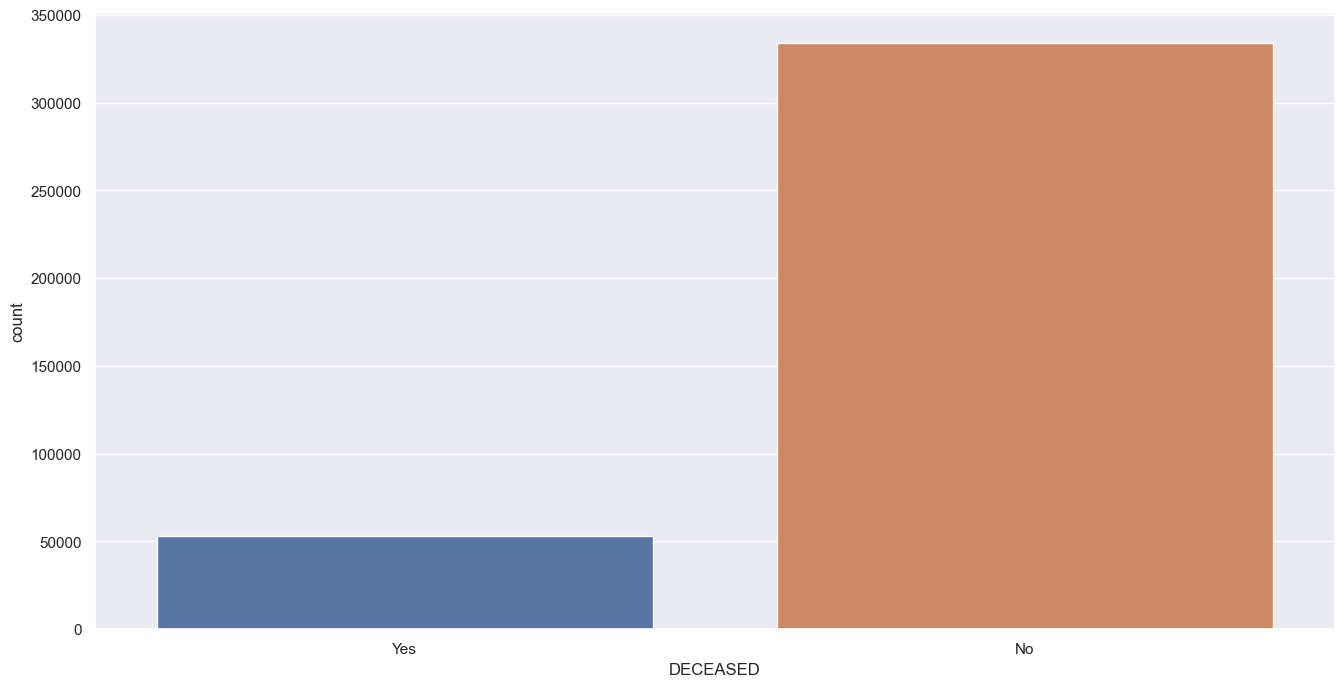

In [ ]:
condition_yes = (df['DATE_DIED'] != '9999-99-99')
condition_no = (df['DATE_DIED'] == '9999-99-99')

# Create a new column based on the conditions
df['DECEASED'] = np.where(condition_yes, 'Yes', 'No')

count_death_yes = df[condition_yes].shape[0]
count_death_no = df[condition_no].shape[0]

p = sns.countplot(data=df, x="DECEASED")
plt.show()

##Dyskretyzacja 'AGE' na 5 grup

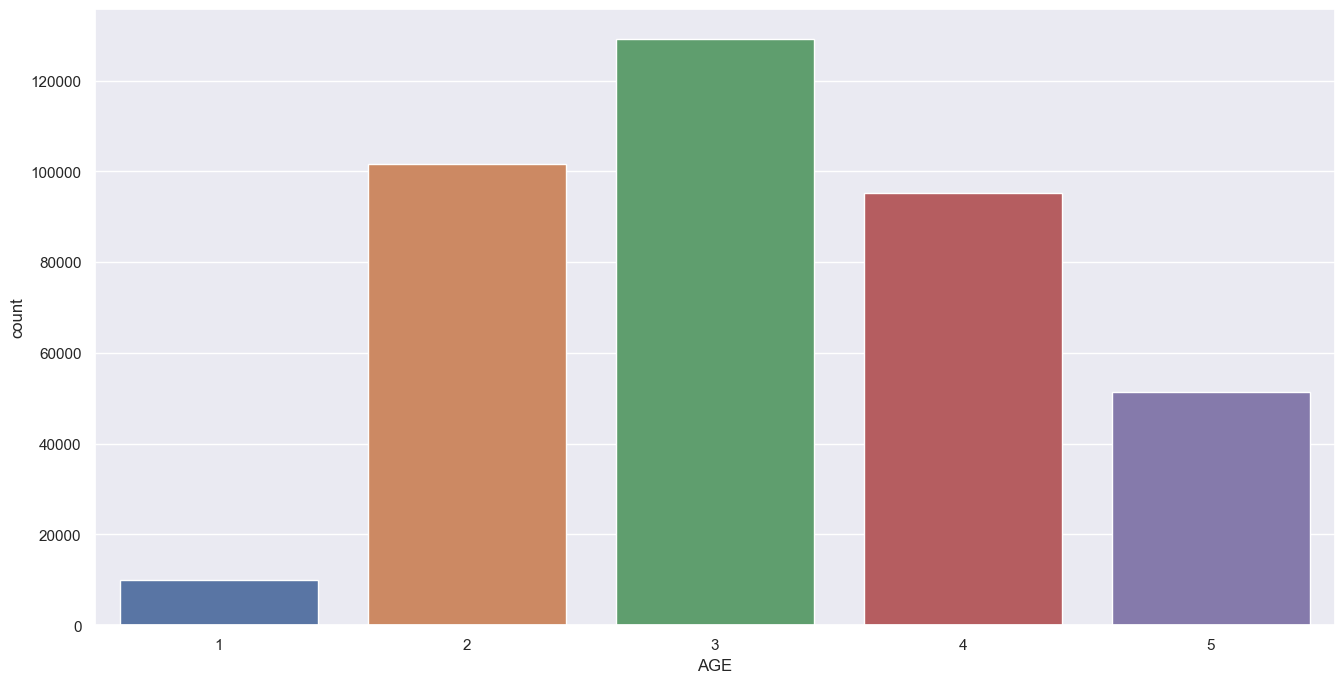

In [ ]:
age_bins = [0, 18, 35, 50, 65, np.inf]
age_labels = [1, 2, 3, 4, 5]
#['Child', 'Young Adult', 'Adult', 'Middle-Aged', 'Senior']
df['AGE'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels, right=False)

p = sns.countplot(data=df, x="AGE")
plt.show()

# Trenowanie Danych

In [ ]:
x = df.drop(columns=['DECEASED', 'DATE_DIED'])
y = df['DECEASED']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2077, stratify=y)

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
results_list = []

In [ ]:
def trainModel(model, x_train, y_train, x_test, y_test, name):
    model.fit(x_train, y_train)
    predicted_output = model.predict(x_test)
    
    confusionMatrix = confusion_matrix(y_test, predicted_output)
    trueNegative = confusionMatrix[0][0]
    falseNegative = confusionMatrix[1][0]
    truePositive = confusionMatrix[1][1]
    falsePositive = confusionMatrix[0][1]

    accuracy = (trueNegative + truePositive) / (trueNegative + falseNegative + truePositive + falsePositive) * 100
    trueNegativeRatio = trueNegative / (trueNegative + falsePositive)* 100
    falseNegativeRatio = falseNegative / (falseNegative + truePositive)* 100
    truePositiveRatio = truePositive / (truePositive + falseNegative)* 100
    falsePositiveRatio = falsePositive / (trueNegative + falsePositive)* 100

    print(name)
    print()
    print("Confusion Matrix:")
    print(confusionMatrix)
    print()
    print("Accuracy:", round(accuracy, 2),  "%")
    print()    
    print("True Positive Ratio:", round(truePositiveRatio, 2),  "%")
    print("True Negative Ratio:", round(trueNegativeRatio, 2),  "%")
    print("False Positive Ratio:", round(falsePositiveRatio, 2),  "%")
    print("False Negative Ratio:", round(falseNegativeRatio, 2),  "%")

    classificationReport = classification_report(y_test, predicted_output)
    print(f"\nClassification Report of {name} Algorithm:")
    print(classificationReport)
    
    result = {
        "name": name,
        "accuracy": round(accuracy, 2),
        "true_positive_ratio": round(truePositiveRatio, 2),
        "true_negative_ratio": round(trueNegativeRatio, 2),
        "false_positive_ratio": round(falsePositiveRatio, 2),
        "false_negative_ratio": round(falseNegativeRatio, 2),
        "confusion_matrix": confusionMatrix,
        "classification_report": classification_report(y_test, predicted_output)
    }

    results_list.append(result)


In [ ]:
trainModel(GaussianNB(), x_train, y_train, x_test, y_test, name='Naive Bayes')

Naive Bayes

Confusion Matrix:
[[55267 11588]
 [ 1353  9312]]

Accuracy: 83.31 %

True Positive Ratio: 87.31 %
True Negative Ratio: 82.67 %
False Positive Ratio: 17.33 %
False Negative Ratio: 12.69 %

Classification Report of Naive Bayes Algorithm:
              precision    recall  f1-score   support

          No       0.98      0.83      0.90     66855
         Yes       0.45      0.87      0.59     10665

    accuracy                           0.83     77520
   macro avg       0.71      0.85      0.74     77520
weighted avg       0.90      0.83      0.85     77520



In [ ]:
trainModel(LogisticRegression(max_iter=10000), x_train, y_train, x_test, y_test, "Logistic regression")

Logistic regression

Confusion Matrix:
[[63785  3070]
 [ 4607  6058]]

Accuracy: 90.1 %

True Positive Ratio: 56.8 %
True Negative Ratio: 95.41 %
False Positive Ratio: 4.59 %
False Negative Ratio: 43.2 %

Classification Report of Logistic regression Algorithm:
              precision    recall  f1-score   support

          No       0.93      0.95      0.94     66855
         Yes       0.66      0.57      0.61     10665

    accuracy                           0.90     77520
   macro avg       0.80      0.76      0.78     77520
weighted avg       0.90      0.90      0.90     77520



In [ ]:
trainModel(KNeighborsClassifier(n_neighbors = 1), x_train, y_train, x_test, y_test, "K=1 Nearest Neighbours")

K=1 Nearest Neighbours

Confusion Matrix:
[[62773  4082]
 [ 4713  5952]]

Accuracy: 88.65 %

True Positive Ratio: 55.81 %
True Negative Ratio: 93.89 %
False Positive Ratio: 6.11 %
False Negative Ratio: 44.19 %

Classification Report of K=1 Nearest Neighbours Algorithm:
              precision    recall  f1-score   support

          No       0.93      0.94      0.93     66855
         Yes       0.59      0.56      0.58     10665

    accuracy                           0.89     77520
   macro avg       0.76      0.75      0.75     77520
weighted avg       0.88      0.89      0.89     77520



In [ ]:
trainModel(KNeighborsClassifier(n_neighbors = 3), x_train, y_train, x_test, y_test, "K=3 Nearest Neighbours")

K=3 Nearest Neighbours

Confusion Matrix:
[[63151  3704]
 [ 4448  6217]]

Accuracy: 89.48 %

True Positive Ratio: 58.29 %
True Negative Ratio: 94.46 %
False Positive Ratio: 5.54 %
False Negative Ratio: 41.71 %

Classification Report of K=3 Nearest Neighbours Algorithm:
              precision    recall  f1-score   support

          No       0.93      0.94      0.94     66855
         Yes       0.63      0.58      0.60     10665

    accuracy                           0.89     77520
   macro avg       0.78      0.76      0.77     77520
weighted avg       0.89      0.89      0.89     77520



In [ ]:
trainModel(KNeighborsClassifier(n_neighbors = 5), x_train, y_train, x_test, y_test, "K=5 Nearest Neighbours")

K=5 Nearest Neighbours

Confusion Matrix:
[[63687  3168]
 [ 4583  6082]]

Accuracy: 90.0 %

True Positive Ratio: 57.03 %
True Negative Ratio: 95.26 %
False Positive Ratio: 4.74 %
False Negative Ratio: 42.97 %

Classification Report of K=5 Nearest Neighbours Algorithm:
              precision    recall  f1-score   support

          No       0.93      0.95      0.94     66855
         Yes       0.66      0.57      0.61     10665

    accuracy                           0.90     77520
   macro avg       0.80      0.76      0.78     77520
weighted avg       0.89      0.90      0.90     77520



In [ ]:
trainModel(KNeighborsClassifier(n_neighbors = 7), x_train, y_train, x_test, y_test, "K=7 Nearest Neighbours")

K=7 Nearest Neighbours

Confusion Matrix:
[[63805  3050]
 [ 4518  6147]]

Accuracy: 90.24 %

True Positive Ratio: 57.64 %
True Negative Ratio: 95.44 %
False Positive Ratio: 4.56 %
False Negative Ratio: 42.36 %

Classification Report of K=7 Nearest Neighbours Algorithm:
              precision    recall  f1-score   support

          No       0.93      0.95      0.94     66855
         Yes       0.67      0.58      0.62     10665

    accuracy                           0.90     77520
   macro avg       0.80      0.77      0.78     77520
weighted avg       0.90      0.90      0.90     77520



In [ ]:
trainModel(LinearSVC(random_state=0, tol=1e-5), x_train, y_train, x_test, y_test, "Support Vector Machine")

Support Vector Machine

Confusion Matrix:
[[64287  2568]
 [ 4730  5935]]

Accuracy: 90.59 %

True Positive Ratio: 55.65 %
True Negative Ratio: 96.16 %
False Positive Ratio: 3.84 %
False Negative Ratio: 44.35 %

Classification Report of Support Vector Machine Algorithm:
              precision    recall  f1-score   support

          No       0.93      0.96      0.95     66855
         Yes       0.70      0.56      0.62     10665

    accuracy                           0.91     77520
   macro avg       0.81      0.76      0.78     77520
weighted avg       0.90      0.91      0.90     77520



In [ ]:
trainModel(tree.DecisionTreeClassifier(), x_train, y_train, x_test, y_test, "Decision Tree")

Decision Tree

Confusion Matrix:
[[64499  2356]
 [ 4661  6004]]

Accuracy: 90.95 %

True Positive Ratio: 56.3 %
True Negative Ratio: 96.48 %
False Positive Ratio: 3.52 %
False Negative Ratio: 43.7 %

Classification Report of Decision Tree Algorithm:
              precision    recall  f1-score   support

          No       0.93      0.96      0.95     66855
         Yes       0.72      0.56      0.63     10665

    accuracy                           0.91     77520
   macro avg       0.83      0.76      0.79     77520
weighted avg       0.90      0.91      0.90     77520



In [ ]:
trainModel(RandomForestClassifier(n_estimators=100, random_state=42), x_train, y_train, x_test, y_test, "Random Forest")

Random Forest

Confusion Matrix:
[[64412  2443]
 [ 4403  6262]]

Accuracy: 91.17 %

True Positive Ratio: 58.72 %
True Negative Ratio: 96.35 %
False Positive Ratio: 3.65 %
False Negative Ratio: 41.28 %

Classification Report of Random Forest Algorithm:
              precision    recall  f1-score   support

          No       0.94      0.96      0.95     66855
         Yes       0.72      0.59      0.65     10665

    accuracy                           0.91     77520
   macro avg       0.83      0.78      0.80     77520
weighted avg       0.91      0.91      0.91     77520



In [ ]:
df_results = pd.DataFrame(results_list)

accuracy_table = df_results[['name', 'accuracy']].sort_values(by='accuracy', ascending=False)
df_results_sorted_true_positive = df_results.sort_values(by='true_positive_ratio', ascending=False)
df_results_sorted_true_negative = df_results.sort_values(by='true_negative_ratio', ascending=False)
df_results_sorted_false_positive = df_results.sort_values(by='false_positive_ratio', ascending=True)
df_results_sorted_false_negative = df_results.sort_values(by='false_negative_ratio', ascending=True)

headers = ["Algorithm", "Accuracy"]
table = f"| {' | '.join(headers)} |\n|{'|'.join(['---']*len(headers))}|\n"
table += '\n'.join([f"| {row['name']} | {row['accuracy']}% |" for _, row in accuracy_table.iterrows()])

true_positive_table = f"| Algorithm | True Positive Ratio |\n|---|---|\n"
true_positive_table += '\n'.join([f"| {row['name']} | {row['true_positive_ratio']}% |" for _, row in df_results_sorted_true_positive.iterrows()])

true_negative_table = f"| Algorithm | True Negative Ratio |\n|---|---|\n"
true_negative_table += '\n'.join([f"| {row['name']} | {row['true_negative_ratio']}% |" for _, row in df_results_sorted_true_negative.iterrows()])

false_positive_table = f"| Algorithm | False Positive Ratio |\n|---|---|\n"
false_positive_table += '\n'.join([f"| {row['name']} | {row['false_positive_ratio']}% |" for _, row in df_results_sorted_false_positive.iterrows()])

false_negative_table = f"| Algorithm | False Negative Ratio |\n|---|---|\n"
false_negative_table += '\n'.join([f"| {row['name']} | {row['false_negative_ratio']}% |" for _, row in df_results_sorted_false_negative.iterrows()])

display(Markdown(table))
display(Markdown(true_positive_table))
display(Markdown(true_negative_table))
display(Markdown(false_positive_table))
display(Markdown(false_negative_table))

| Algorithm | Accuracy |
|---|---|
| Random Forest | 91.17% |
| Decision Tree | 90.95% |
| Support Vector Machine | 90.59% |
| K=7 Nearest Neighbours | 90.24% |
| Logistic regression | 90.1% |
| K=5 Nearest Neighbours | 90.0% |
| K=3 Nearest Neighbours | 89.48% |
| K=1 Nearest Neighbours | 88.65% |
| Naive Bayes | 83.31% |

| Algorithm | True Positive Ratio |
|---|---|
| Naive Bayes | 87.31% |
| Random Forest | 58.72% |
| K=3 Nearest Neighbours | 58.29% |
| K=7 Nearest Neighbours | 57.64% |
| K=5 Nearest Neighbours | 57.03% |
| Logistic regression | 56.8% |
| Decision Tree | 56.3% |
| K=1 Nearest Neighbours | 55.81% |
| Support Vector Machine | 55.65% |

| Algorithm | True Negative Ratio |
|---|---|
| Decision Tree | 96.48% |
| Random Forest | 96.35% |
| Support Vector Machine | 96.16% |
| K=7 Nearest Neighbours | 95.44% |
| Logistic regression | 95.41% |
| K=5 Nearest Neighbours | 95.26% |
| K=3 Nearest Neighbours | 94.46% |
| K=1 Nearest Neighbours | 93.89% |
| Naive Bayes | 82.67% |

| Algorithm | False Positive Ratio |
|---|---|
| Decision Tree | 3.52% |
| Random Forest | 3.65% |
| Support Vector Machine | 3.84% |
| K=7 Nearest Neighbours | 4.56% |
| Logistic regression | 4.59% |
| K=5 Nearest Neighbours | 4.74% |
| K=3 Nearest Neighbours | 5.54% |
| K=1 Nearest Neighbours | 6.11% |
| Naive Bayes | 17.33% |

| Algorithm | False Negative Ratio |
|---|---|
| Naive Bayes | 12.69% |
| Random Forest | 41.28% |
| K=3 Nearest Neighbours | 41.71% |
| K=7 Nearest Neighbours | 42.36% |
| K=5 Nearest Neighbours | 42.97% |
| Logistic regression | 43.2% |
| Decision Tree | 43.7% |
| K=1 Nearest Neighbours | 44.19% |
| Support Vector Machine | 44.35% |

#GridSearch

In [ ]:
results_list_grid_search = []

In [ ]:
def trainModelWithGridSearchCV(model, parameters, x_train, y_train, x_test, y_test, name):
    
    cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=2077)

    gridSearch = GridSearchCV(model, parameters, cv=cv_stratified, scoring='accuracy', n_jobs=-1, verbose=3)
    gridSearch.fit(x_train, y_train)    

    predicted_output = gridSearch.predict(x_test)

    confusionMatrix = confusion_matrix(y_test, predicted_output)
    trueNegative = confusionMatrix[0][0]
    falseNegative = confusionMatrix[1][0]
    truePositive = confusionMatrix[1][1]
    falsePositive = confusionMatrix[0][1]

    accuracy = (trueNegative + truePositive) / (trueNegative + falseNegative + truePositive + falsePositive) * 100
    trueNegativeRatio = trueNegative / (trueNegative + falsePositive)* 100
    falseNegativeRatio = falseNegative / (falseNegative + truePositive)* 100
    truePositiveRatio = truePositive / (truePositive + falseNegative)* 100
    falsePositiveRatio = falsePositive / (trueNegative + falsePositive)* 100

    print(name)
    print()
    print("Confusion Matrix:")
    print(confusionMatrix)
    print()
    print("Accuracy:", round(accuracy, 2),  "%")
    print()    
    print("True Positive Ratio:", round(truePositiveRatio, 2),  "%")
    print("True Negative Ratio:", round(trueNegativeRatio, 2),  "%")
    print("False Positive Ratio:", round(falsePositiveRatio, 2),  "%")
    print("False Negative Ratio:", round(falseNegativeRatio, 2),  "%")

    classificationReport = classification_report(y_test, predicted_output)
    print(f"\nClassification Report of {name} Algorithm:")
    print("\nBest Estimator: ", gridSearch.best_estimator_)
    print(classificationReport)    
    result = {
        "name": name,
        "accuracy": round(accuracy, 2),
        "true_positive_ratio": round(truePositiveRatio, 2),
        "true_negative_ratio": round(trueNegativeRatio, 2),
        "false_positive_ratio": round(falsePositiveRatio, 2),
        "false_negative_ratio": round(falseNegativeRatio, 2),
        "confusion_matrix": confusionMatrix,
        "classification_report": classification_report(y_test, predicted_output)
    }

    results_list_grid_search.append(result)


In [ ]:
#knn__GSCV = KNeighborsClassifier()
#parameters_KNN = { "n_neighbors": [1,2,3,4,5,6,7,8,9,10], "algorithm": ["ball_tree", "kd_tree", "brute"] }

#trainModelWithGridSearchCV(knn__GSCV, parameters_KNN, x_train, y_train, x_test, y_test, "Nearest Neighbours")

In [ ]:
svc__GSCV = LinearSVC(random_state=2077, tol=1e-5)
parameters_SVC = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l2'], 'loss': ['hinge', 'squared_hinge'],
}

trainModelWithGridSearchCV(svc__GSCV, parameters_SVC,x_train, y_train, x_test, y_test, "SVC")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
SVC

Confusion Matrix:
[[64291  2564]
 [ 4746  5919]]

Accuracy: 90.57 %

True Positive Ratio: 55.5 %
True Negative Ratio: 96.16 %
False Positive Ratio: 3.84 %
False Negative Ratio: 44.5 %

Classification Report of SVC Algorithm:

Best Estimator:  LinearSVC(C=1, random_state=2077, tol=1e-05)
              precision    recall  f1-score   support

          No       0.93      0.96      0.95     66855
         Yes       0.70      0.55      0.62     10665

    accuracy                           0.91     77520
   macro avg       0.81      0.76      0.78     77520
weighted avg       0.90      0.91      0.90     77520



In [ ]:
random_forest_GSCV = RandomForestClassifier(random_state=2077, n_jobs=-1, max_features="auto", warm_start=True)
parameters_RF = { "max_depth": range(5,10,1), "min_samples_leaf": range(1,10,1), "n_estimators": range(1,10,1) }    

trainModelWithGridSearchCV(random_forest_GSCV, parameters_RF, x_train, y_train, x_test, y_test, "Random Forest")

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Random Forest

Confusion Matrix:
[[65340  1515]
 [ 5213  5452]]

Accuracy: 91.32 %

True Positive Ratio: 51.12 %
True Negative Ratio: 97.73 %
False Positive Ratio: 2.27 %
False Negative Ratio: 48.88 %

Classification Report of Random Forest Algorithm:

Best Estimator:  RandomForestClassifier(max_depth=9, max_features='auto', min_samples_leaf=2,
                       n_estimators=9, n_jobs=-1, random_state=2077,
                       warm_start=True)
              precision    recall  f1-score   support

          No       0.93      0.98      0.95     66855
         Yes       0.78      0.51      0.62     10665

    accuracy                           0.91     77520
   macro avg       0.85      0.74      0.78     77520
weighted avg       0.91      0.91      0.91     77520



In [ ]:
extra_trees_GSCV = ExtraTreesClassifier(random_state=2077, n_jobs=-1, max_features="auto", warm_start=True)
parameters_ET =  { "criterion": ["gini", "entropy"], "max_depth": range(5,30,5), "min_samples_leaf": range(1,10,2), "n_estimators": range(1,10,1) }

trainModelWithGridSearchCV(extra_trees_GSCV, parameters_ET, x_train, y_train, x_test, y_test, "Extra Trees")

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Extra Trees

Confusion Matrix:
[[64757  2098]
 [ 4506  6159]]

Accuracy: 91.48 %

True Positive Ratio: 57.75 %
True Negative Ratio: 96.86 %
False Positive Ratio: 3.14 %
False Negative Ratio: 42.25 %

Classification Report of Extra Trees Algorithm:

Best Estimator:  ExtraTreesClassifier(criterion='entropy', max_depth=20, max_features='auto',
                     min_samples_leaf=7, n_estimators=9, n_jobs=-1,
                     random_state=2077, warm_start=True)
              precision    recall  f1-score   support

          No       0.93      0.97      0.95     66855
         Yes       0.75      0.58      0.65     10665

    accuracy                           0.91     77520
   macro avg       0.84      0.77      0.80     77520
weighted avg       0.91      0.91      0.91     77520



In [ ]:
df_results = pd.DataFrame(results_list_grid_search)

accuracy_table = df_results[['name', 'accuracy']].sort_values(by='accuracy', ascending=False)
df_results_sorted_true_positive = df_results.sort_values(by='true_positive_ratio', ascending=False)
df_results_sorted_true_negative = df_results.sort_values(by='true_negative_ratio', ascending=False)
df_results_sorted_false_positive = df_results.sort_values(by='false_positive_ratio', ascending=True)
df_results_sorted_false_negative = df_results.sort_values(by='false_negative_ratio', ascending=True)

headers = ["Algorithm", "Accuracy"]
table = f"| {' | '.join(headers)} |\n|{'|'.join(['---']*len(headers))}|\n"
table += '\n'.join([f"| {row['name']} | {row['accuracy']}% |" for _, row in accuracy_table.iterrows()])

true_positive_table = f"| Algorithm | True Positive Ratio |\n|---|---|\n"
true_positive_table += '\n'.join([f"| {row['name']} | {row['true_positive_ratio']}% |" for _, row in df_results_sorted_true_positive.iterrows()])

true_negative_table = f"| Algorithm | True Negative Ratio |\n|---|---|\n"
true_negative_table += '\n'.join([f"| {row['name']} | {row['true_negative_ratio']}% |" for _, row in df_results_sorted_true_negative.iterrows()])

false_positive_table = f"| Algorithm | False Positive Ratio |\n|---|---|\n"
false_positive_table += '\n'.join([f"| {row['name']} | {row['false_positive_ratio']}% |" for _, row in df_results_sorted_false_positive.iterrows()])

false_negative_table = f"| Algorithm | False Negative Ratio |\n|---|---|\n"
false_negative_table += '\n'.join([f"| {row['name']} | {row['false_negative_ratio']}% |" for _, row in df_results_sorted_false_negative.iterrows()])

display(Markdown(table))
display(Markdown(true_positive_table))
display(Markdown(true_negative_table))
display(Markdown(false_positive_table))
display(Markdown(false_negative_table))

| Algorithm | Accuracy |
|---|---|
| Extra Trees | 91.48% |
| Random Forest | 91.32% |
| SVC | 90.57% |

| Algorithm | True Positive Ratio |
|---|---|
| Extra Trees | 57.75% |
| SVC | 55.5% |
| Random Forest | 51.12% |

| Algorithm | True Negative Ratio |
|---|---|
| Random Forest | 97.73% |
| Extra Trees | 96.86% |
| SVC | 96.16% |

| Algorithm | False Positive Ratio |
|---|---|
| Random Forest | 2.27% |
| Extra Trees | 3.14% |
| SVC | 3.84% |

| Algorithm | False Negative Ratio |
|---|---|
| Extra Trees | 42.25% |
| SVC | 44.5% |
| Random Forest | 48.88% |